# Basic end-to-end training of a LightGBM model
_To be added next:_ 
- An example of Bayesian Optimisation (inspired by the comment in [this kernel](https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/))- this is not expected to bring singificant improvement, but it is a fun technique to exercise

Features that are illustrated in this kernel:
- data reading with **memory footprint reduction**
- categorical feature encoding using **one-hot-encoding (OHE)**
-  internal **category weighting** by _**LightGBM**_ was tuned and no need of resampling is shown
- **gradient-boosted decision trees** using _**LightGBM**_ package
- **early stopping** in _**LightGBM**_ model training to avoid overtraining
- **learning rate decay** in _**LightGBM**_ model training to improve convergence to the minimum
- **hyperparameter optimisation** of the model using random search in cross validation
- submission preparation
This kernel inherited ideas and SW solutions from other public kernels and in such cases I will post direct references to the original product, that that you can get some additional insights from the source.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import gc
%matplotlib inline 
plt.xkcd()

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
PATH = "../data/home-credit-default-risk/"
print(os.listdir(PATH))

# Any results you write to the current directory are saved as output.

['application_test.csv', 'bureau_balance.csv.zip', 'application_train.csv.zip', 'credit_card_balance.csv.zip', 'application_test.csv.zip', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'installments_payments.csv.zip', 'bureau.csv', 'POS_CASH_balance.csv.zip', 'previous_application.csv', 'bureau.csv.zip', 'bureau_balance.csv', 'previous_application.csv.zip', 'sample_submission.csv.zip', 'sample_submission.csv']


## Read in the data reducing memory pattern for variables.
The implementation was copied over from [this kernel](https://www.kaggle.com/gemartin/load-data-reduce-memory-usage)

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

# TODO: more month specific min/max/mean. Weighted moving average maybe
# Preprocess bureau.csv and bureau_balance.csv
# From: https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features/code
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = import_data(PATH + 'bureau.csv')
    bb = import_data(PATH + 'bureau_balance.csv')
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat: bb_aggregations[col] = ['mean']

    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categoricinterstingal features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# TODO: more month specific min/max/mean
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = import_data(PATH+'previous_application.csv')
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = import_data(PATH + 'POS_CASH_balance.csv')
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = import_data(PATH + 'installments_payments.csv')
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = import_data(PATH + 'credit_card_balance.csv')
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object' or str(df[col].dtype) == 'category']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [3]:
application_train = import_data(PATH+'application_train.csv')
application_test = import_data(PATH+'application_test.csv')
bureau = bureau_and_balance()
prev = previous_applications()
pos = pos_cash()
ins = installments_payments()
cc = credit_card_balance()

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 59.54 MB
Decreased by 79.2%
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 9.40 MB
Decreased by 79.1%
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 78.57 MB
Decreased by 64.7%
Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 156.21 MB
Decreased by 75.0%
Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 130.62 MB
Decreased by 72.3%
Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 171.69 MB
Decreased by 71.9%
Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 263.69 MB
Decreased by 60.9%


Bureau data has good number of users covered

The following 2 cells with cleaning criteria were inherited from [this kernel](https://www.kaggle.com/kingychiu/home-credit-eda-distributions-and-outliers)

In [4]:
application_train = application_train[application_train['AMT_INCOME_TOTAL'] != 1.170000e+08]
application_train = application_train[application_train['AMT_REQ_CREDIT_BUREAU_QRT'] != 261]
application_train = application_train[application_train['OBS_30_CNT_SOCIAL_CIRCLE'] < 300]

In [5]:
application_train['DAYS_EMPLOYED'] = (application_train['DAYS_EMPLOYED'].apply(lambda x: x if x != 365243 else np.nan))

## Additional numerical columns constructed from EXT_SOURCE_x

In [6]:
def feat_ext_source(df):
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    df2 = df[df['CODE_GENDER'] != 'XNA'].copy()
    del df
    df = df2

    x1 = df['EXT_SOURCE_1'].fillna(-1) + 1e-1
    x2 = df['EXT_SOURCE_2'].fillna(-1) + 1e-1
    x3 = df['EXT_SOURCE_3'].fillna(-1) + 1e-1
    
    df['EXT_SOURCE_1over2_NAminus1_Add0.1'] = x1/x2
    df['EXT_SOURCE_2over1_NAminus1_Add0.1'] = x2/x1
    df['EXT_SOURCE_1over3_NAminus1_Add0.1'] = x1/x3
    df['EXT_SOURCE_3over1_NAminus1_Add0.1'] = x3/x1
    df['EXT_SOURCE_2over3_NAminus1_Add0.1'] = x2/x3
    df['EXT_SOURCE_3over2_NAminus1_Add0.1'] = x3/x2
    
    df['EXT_SOURCE_na1_2'] = (application_train['EXT_SOURCE_1'].isnull()) * (application_train['EXT_SOURCE_2'].fillna(0))
    df['EXT_SOURCE_na1_3'] = (application_train['EXT_SOURCE_1'].isnull()) * (application_train['EXT_SOURCE_3'].fillna(0))
    df['EXT_SOURCE_na2_1'] = (application_train['EXT_SOURCE_2'].isnull()) * (application_train['EXT_SOURCE_1'].fillna(0))
    df['EXT_SOURCE_na2_3'] = (application_train['EXT_SOURCE_2'].isnull()) * (application_train['EXT_SOURCE_3'].fillna(0))
    df['EXT_SOURCE_na3_1'] = (application_train['EXT_SOURCE_3'].isnull()) * (application_train['EXT_SOURCE_1'].fillna(0))
    df['EXT_SOURCE_na3_2'] = (application_train['EXT_SOURCE_3'].isnull()) * (application_train['EXT_SOURCE_2'].fillna(0))
    
    return df

In [7]:
application_train = feat_ext_source(application_train)
application_test  = feat_ext_source(application_test)

## Categorical encoding
The function was taken from [this kernel](https://www.kaggle.com/sz8416/simple-intro-eda-baseline-model-with-gridsearch). It allows to do OneHotEncoding (OHE) keeping only those columns that are common to train and test samples. OHE is performed using `pd.get_dummies`, which allows to convert categorical features, while keeping numerical untouched

In [8]:
# use this if you want to convert categorical features to dummies(default)
def cat_to_dummy(train, test):
    train_d = pd.get_dummies(train, drop_first=False)
    test_d = pd.get_dummies(test, drop_first=False)
    # make sure that the number of features in train and test should be same
    for i in train_d.columns:
        if i not in test_d.columns:
            if i!='TARGET':
                train_d = train_d.drop(i, axis=1)
    for j in test_d.columns:
        if j not in train_d.columns:
            if j!='TARGET':
                test_d = test_d.drop(i, axis=1)
    print('Memory usage of train increases from {:.2f} to {:.2f} MB'.format(train.memory_usage().sum() / 1024**2, 
                                                                            train_d.memory_usage().sum() / 1024**2))
    print('Memory usage of test increases from {:.2f} to {:.2f} MB'.format(test.memory_usage().sum() / 1024**2, 
                                                                            test_d.memory_usage().sum() / 1024**2))
    return train_d, test_d

application_train_ohe, application_test_ohe = cat_to_dummy(application_train, application_test)

for join_df in [bureau, prev, pos, ins, cc]:
    application_train_ohe = application_train_ohe.join(join_df, how='left', on='SK_ID_CURR')
    application_test_ohe = application_test_ohe.join(join_df, how='left', on='SK_ID_CURR')
    
application_train_ohe = reduce_mem_usage(application_train_ohe)
application_test_ohe = reduce_mem_usage(application_test_ohe)

Memory usage of train increases from 86.88 to 122.24 MB
Memory usage of test increases from 12.00 to 17.62 MB
Memory usage of dataframe is 1135.30 MB
Memory usage after optimization is: 585.51 MB
Decreased by 48.4%
Memory usage of dataframe is 178.74 MB
Memory usage after optimization is: 90.18 MB
Decreased by 49.5%


## Deal with category imbalance
Use a standard library (`imblearn`) to to random undersampling on the dominating category. Use if if you want to repeat the HP optimisation

In [9]:
# You can use the full sample and do sample weighting in lightgbm using `is_unbalance` OR `scale_pos_weight` argument
# But it makes the code to run 8x..10x slower, which is ok for the run with pre-optimised parametersm but is too slow for HP optimisation
X_rus, y_rus = (application_train_ohe.drop(['SK_ID_CURR', 'TARGET'], axis=1),
                application_train_ohe['TARGET'])

# Model fitting with HyperParameter optimisation
We will use LightGBM classifier - LightGBM allows to build very sophysticated models with a very short training time.
### Split the full sample into train/test (80/20)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.20, random_state=314, stratify=y_rus)

### Prepare learning rate shrinkage

In [11]:
def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

### Use test subset for early stopping criterion 
This allows us to avoid overtraining and we do not need to optimise the number of trees

In [12]:
import lightgbm as lgb
fit_params={"early_stopping_rounds":20, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

### Set up HyperParameter search
We use random search, which is more flexible and more efficient than a grid search

In [13]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
# param_test ={'num_leaves': sp_randint(6, 50), 
#              'min_child_samples': sp_randint(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': sp_uniform(loc=0.2, scale=0.8), 
#              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

# Custom
param_test ={'num_leaves': sp_randint(10, 20), 
             'min_child_samples': sp_randint(250, 450), 
             'min_child_weight': [1e-2, 1e-1, 1, 1e1],
             'subsample': [0.8],
             "max_depth": [8, 12],
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1, 2, 5],
             'reg_lambda': [0, 1, 5]}
param_test = {'colsample_bytree': [0.95], 'max_depth': [10],
              'min_child_samples': [429], 'min_child_weight': [1],
              'num_leaves': [12], 'reg_alpha': [5], 'reg_lambda': [5],
              'subsample': [0.8, 0.85]}

In [14]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 2

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 1000 define only the absolute maximum
clf = lgb.LGBMClassifier(num_iterations=250, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=600)
gs = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

Run this cell, to do HP optimisation. To save time `opt_parameters` was directly hardcoded below.

In [15]:
# gs.fit(X_train, y_train, **fit_params)
# print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

# Derived optimal parameters
# opt_parameters = {'colsample_bytree': 0.9234, 'min_child_samples': 399, 'min_child_weight': 0.1, 'num_leaves': 13, 'reg_alpha': 2, 'reg_lambda': 5, 'subsample': 0.855}
opt_parameters = {'colsample_bytree': 0.95, 'max_depth': 10, 'min_child_samples': 429, 'min_child_weight': 1, 'num_leaves': 25, 'reg_alpha': 0.041, 'reg_lambda': 0.073, 'subsample': 0.87}

## Tune the weights of unbalanced classes
Following discussion in [this comment](https://www.kaggle.com/mlisovyi/modular-good-fun-with-ligthgbm/comments#337494), there was a small tuning of the disbalanced sample weight:


In [16]:
clf_sw = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_sw.set_params(**opt_parameters)

gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[12]},
                                scoring='roc_auc',
                                cv=3,
                                refit=True,
                                verbose=True)

gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/nitin/.local/share/virtualenvs/ownwork-7IQXCDiI/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds.
[100]	valid's auc: 0.785934
Early stopping, best iteration is:
[148]	valid's auc: 0.787832


/Users/nitin/.local/share/virtualenvs/ownwork-7IQXCDiI/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds.
[100]	valid's auc: 0.783846
Early stopping, best iteration is:
[98]	valid's auc: 0.783919


/Users/nitin/.local/share/virtualenvs/ownwork-7IQXCDiI/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds.
[100]	valid's auc: 0.785355
Early stopping, best iteration is:
[177]	valid's auc: 0.786838


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.8min finished
/Users/nitin/.local/share/virtualenvs/ownwork-7IQXCDiI/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds.
[100]	valid's auc: 0.787384
[200]	valid's auc: 0.790699
Did not meet early stopping. Best iteration is:
[250]	valid's auc: 0.791382
Best score reached: 0.7809114767052509 with params: {'scale_pos_weight': 12} 


As an outcome, precision of the classifier does not depend much on the internal class weighting, but `weight=1` still turns out to give slightly better performance that weighted scenarios.

### Look at the performance of the top-5 parameter choices
(the list is inverted)

In [68]:
#print("Valid+-Std     Train  :   Parameters")
#for i in np.argsort(gs.cv_results_['mean_test_score'])[-5:]:
#    print('{1:.3f}+-{3:.3f}     {2:.3f}   :  {0}'.format(gs.cv_results_['params'][i], 
#                                    gs.cv_results_['mean_test_score'][i], 
#                                    gs.cv_results_['mean_train_score'][i],
#                                    gs.cv_results_['std_test_score'][i]))

In [17]:
print("Valid+-Std     Train  :   Parameters")
for i in np.argsort(gs_sample_weight.cv_results_['mean_test_score'])[-5:]:
    print('{1:.3f}+-{3:.3f}     {2:.3f}   :  {0}'.format(gs_sample_weight.cv_results_['params'][i], 
                                    gs_sample_weight.cv_results_['mean_test_score'][i], 
                                    gs_sample_weight.cv_results_['mean_train_score'][i],
                                    gs_sample_weight.cv_results_['std_test_score'][i]))

Valid+-Std     Train  :   Parameters
0.781+-0.002     0.852   :  {'scale_pos_weight': 12}


/Users/nitin/.local/share/virtualenvs/ownwork-7IQXCDiI/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


## Build the final model
We do training with the 0.8 subset of the dataset and 0.2 subset for early stopping. We use the tuned parameter values but a smaller learning rate to allow smoother convergence to the minimum

In [18]:
#Configure from the HP optimisation
#clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#force larger number of max trees and smaller learning rate
clf_final.set_params(n_estimators=3000, learning_rate=0.005, objective='binary', num_iterations=450)
# fit_params["eval_set"] = [(X_test[feat_imp.nlargest(100).keys()],y_test)]
# clf_final.fit(X_train[feat_imp.nlargest(100).keys()], y_train, **fit_params,
#               callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.95,
        learning_rate=0.005, max_depth=10, metric='None',
        min_child_samples=429, min_child_weight=1, min_split_gain=0.0,
        n_estimators=3000, n_jobs=4, num_iterations=450, num_leaves=25,
        objective='binary', random_state=314, reg_alpha=0.041,
        reg_lambda=0.073, silent=True, subsample=0.87,
        subsample_for_bin=200000, subsample_freq=1)

In [19]:
fit_params["eval_set"] = [(X_test,y_test)]
clf_final.fit(X_train, y_train, **fit_params,
              callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

/Users/nitin/.local/share/virtualenvs/ownwork-7IQXCDiI/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds.
[100]	valid's auc: 0.782321
[200]	valid's auc: 0.789155
[300]	valid's auc: 0.790698
[400]	valid's auc: 0.791412
Did not meet early stopping. Best iteration is:
[450]	valid's auc: 0.791615


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.95,
        learning_rate=0.005, max_depth=10, metric='None',
        min_child_samples=429, min_child_weight=1, min_split_gain=0.0,
        n_estimators=3000, n_jobs=4, num_iterations=450, num_leaves=25,
        objective='binary', random_state=314, reg_alpha=0.041,
        reg_lambda=0.073, silent=True, subsample=0.87,
        subsample_for_bin=200000, subsample_freq=1)

### Plot feature importance

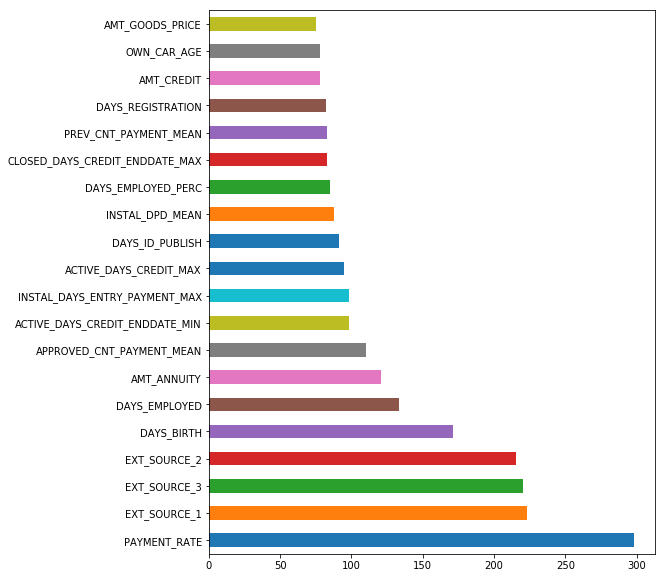

In [20]:
feat_imp = pd.Series(clf_final.feature_importances_, index=application_train_ohe.drop(['SK_ID_CURR', 'TARGET'], axis=1).columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(8,10))

# Predict on the submission test sample

In [21]:
probabilities = clf_final.predict_proba(application_test_ohe.drop(['SK_ID_CURR'], axis=1))
submission = pd.DataFrame({
    'SK_ID_CURR': application_test_ohe['SK_ID_CURR'],
    'TARGET':     [ row[1] for row in probabilities]
})
submission.to_csv("submission.csv", index=False)